---

<div align=center>

# **🖥️ Simulation requirements**

</div>

## 📥 Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.origin'] = 'lower'
import astropy.units as u
from IPython.display import display
import sympy as sp
import fitter
import numba as nb

## 🎛️ Parameters

Simulation parameters:

In [2]:
# Parallactic angle
ALPHA = 70 * u.deg

# Angular spearation
THETA = 7 * u.mas

# Contrast
CONTRAST = 1e-4

<div align=center>
👉 <i><U>Only edit the previous block</u></i>
</div>

Other parameters:

In [3]:
# Wavelength
L = 1.65 * u.um

# Telescopes positions
TELESCOPE_POSITION = np.array([
    [0, 0],
    [1, 1],
    [2, 1.5],
    [3, 0.7],
]) * 42.2 * u.m

# Field of view
FOV = 10 * u.mas

# Kernel-Nuller parameters
INPUT_OPD_RMS = L/100

Processing parameters

In [4]:
TELESCOPE_POSITION = TELESCOPE_POSITION.to(u.m)
ALPHA = ALPHA.to(u.rad)
THETA = THETA.to(u.rad)
INPUT_OPD_RMS = INPUT_OPD_RMS.to(L.unit)
ALPHA_RANGE = np.linspace(0,2*np.pi,360)*u.rad
EXTENT = (-FOV.value, FOV.value, -FOV.value, FOV.value)

## 🔧 Utils

Numpy `random.normal` is not jit-able, so we need to define our own random.normal function

In [5]:
@nb.njit()
def random_normal(scale: float, size: int = 1) -> np.ndarray[float]:
    """Generate an array of random numbers following a normal distribution.
    
    Parameters
    ----------
    - scale: Standard deviation of the normal distribution.
    - size: Number of random numbers to generate.

    Returns
    -------
    - Array of random numbers.
    
    """
    return np.array(
        [
            np.sqrt(-2 * np.log(np.random.rand()))
            * np.cos(2 * np.pi * np.random.rand())
            * scale
            for _ in range(size)
        ]
    )

We only consider relative phases, so we only consider phase shift in `[0,wavelenght[`

In [6]:
@nb.njit()
def bound_phase_njit(phase:float, wavelenght:float=L.value):
    """Bring a phase to the interval [0, wavelenght].

    Parameters
    ----------
    - phase: Phase to bound (in distance unit)
    - wavelenght: Wavelenght of the light (same unit as phase) 

    Returns
    -------
    - Phase in the interval [0, wavelenght]
    """
    return np.mod(phase, wavelenght)

def bound_phase(phase:u.Quantity, wavelenght:u.Quantity=L):
    """Bring a phase to the interval [0, wavelenght].

    Parameters
    ----------
    - phase: Phase to bound
    - wavelenght: Wavelenght of the light

    Returns
    -------
    - Phase in the interval [0, wavelenght]
    """
    return bound_phase_njit(phase.value, wavelenght.to(phase.unit).value) * phase.unit

In [7]:
@nb.njit()
def phase_shift_njit(
    beam: complex | np.ndarray[complex],
    phase: float | np.ndarray[float],
    wavelenght: float = L.value,
) -> complex | np.ndarray[complex]:
    """
    De-phase the input beam by heating the fiber with an electrical current.

    Parameters
    ----------
    - beam: input beam complex amplitude
    - phase: phase to add (in same unit as wavelenght)
    - wavelenght: wavelength

    Returns
    -------
    - Output beam complex amplitude
    """
    return beam * np.exp(1j * 2 * np.pi * phase / wavelenght)


def phase_shift(
    beam: complex | np.ndarray[complex], phase: u.Quantity, wavelenght: u.Quantity = L
) -> complex | np.ndarray[complex]:
    """
    De-phase the input beam by heating the fiber with an electrical current.

    Parameters
    ----------
    - beam: input beam complex amplitude
    - phase: phase to add
    - wavelenght: wavelength

    Returns
    -------
    - Output beam complex amplitude
    """
    return phase_shift_njit(beam, phase.to(wavelenght.unit).value, wavelenght.value)

---

<div align=center>

# 🤔 **Context**

</div>

## 🎯 Goal

We aim to detect make direct detection of exoplanets. There is two main challenges to achieve this goal:
- The **contrast**: the exoplanet is much fainter than the star it orbits. The contrast is typically of the order of $10^{-6}$ to $10^{-10}$.
- The **angular separation**: the exoplanet is very close to the star. The angular separation depend on the distance of the exoplanet to the star and the distance of the star to the observer and can easily goes below the arcsecond.

## 🔎 Detection methods

It exist several methods to detect exoplanets. The most common are:
- **Radial velocity method**: the exoplanet induce a wobble in the star it orbits. This wobble can be detected by the Doppler effect (the light is alternatively redshifted and blueshifted).
- **Transit method**: the exoplanet pass in front of the star and block a fraction of the light. This fraction can be detected by the decrease of the star luminosity.
- **Microlensing**: the exoplanet act as a lens and magnify the light of a background star. This magnification can be detected by the increase of the star luminosity.
- **Astrometry**: the exoplanet induce a wobble in the star it orbits. This wobble can be detected by the change of the star position.
- **Coronography**: the exoplanet is directly imaged. This is the most challenging method because of the contrast and the angular separation.

<div align=center>
<img src="img/detection_methods.jpg" width=500px>
<p><i>Paul Anthony Wilson - Exoplanet detection techniques</i><p>
</div>

Until now, the coronography was the only method allowing direct detection. But it has two main limitations:
- It require huge telescopes in order to have a good angular resolution.
- The contrast we can achieve is limited by unperfect fabrication process of the optical components which lead to undesired diffraction effects.

## 📡 Telescope position

From the telescope position defined in parameters, we need to compute the real position according to the baseline rotation

In [8]:
@nb.njit()
def rotate_baseline_njit(
    telescope_positions: np.ndarray[float] = TELESCOPE_POSITION.value,
    rotation: float = ALPHA.to(u.rad).value
) -> np.ndarray[float]:
    """
    Rotate the telescope positions by an angle alpha.

    Parameters
    ----------
    - telescope_positions: Telescope positions.
    - alpha: Rotation angle in radians.

    Returns
    -------
    - Rotated telescope positions (same shape and unit as telescope_positions)
    """

    real_telescope_positions = np.empty_like(telescope_positions)
    for i in range(telescope_positions.shape[0]):
        x = telescope_positions[i][0]
        y = telescope_positions[i][1]
        a = rotation

        x2 = x * np.cos(a) - y * np.sin(a)
        y2 = x * np.sin(a) + y * np.cos(a)

        real_telescope_positions[i] = [x2, y2]
    return real_telescope_positions

def rotate_baseline(
    telescope_positions: u.Quantity = TELESCOPE_POSITION,
    rotation: u.Quantity = ALPHA
) -> u.Quantity:
    """
    Rotate the telescope positions by an angle alpha.

    Parameters
    ----------
    - telescope_positions: Array of telescope positions.
    - alpha: Rotation angle.

    Returns
    -------
    - Array of rotated telescope positions (same shape and unit as telescope_positions)
    """

    return (
        rotate_baseline_njit(telescope_positions.value, rotation.to(u.rad).value)
        * telescope_positions.unit
    )

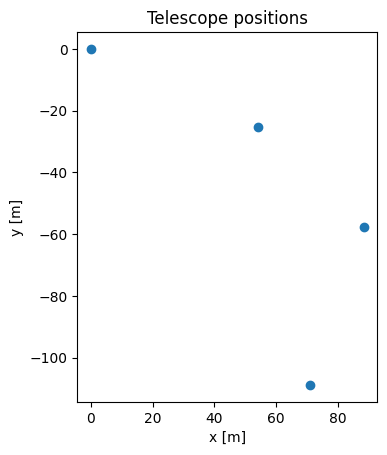

In [9]:
def plot_telescope_position():
    real_telescope_positions = rotate_baseline(TELESCOPE_POSITION, -ALPHA)

    _, ax = plt.subplots()
    ax.scatter(real_telescope_positions[:, 0], real_telescope_positions[:, 1])
    ax.set_aspect("equal")
    ax.set_xlabel(f"x [{real_telescope_positions.unit}]")
    ax.set_ylabel(f"y [{real_telescope_positions.unit}]")
    ax.set_title("Telescope positions")
    plt.show()

plot_telescope_position()

## 🔆 Signal nature

The star and the planet are point sources. Seen from a classical telescope, it will result in an image made of the objects convolution with the point spread function (PSF) of the telescope.

$$
I = O \otimes PSF
$$

Here we consider the most simple PSF : the Airy disk. The Airy disk is the diffraction pattern of a point source by a circular aperture. It is given by:

$$
PSF = \left(\frac{2J_1(x)}{x}\right)^2
$$

where $J_1$ is the Bessel function of the first kind of order 1 and $x = \frac{2\pi r}{\lambda f}$ is the normalized radius of the Airy disk.

Then, we focus the image in a monomode optical fiber which will basically only keep the main lobe of the PSF and reshape it in a Gaussian form. In this process, we lose the spatial information so we have no longer images, but the light flux of each object in the fiber can be simply described by a complex number.

> I don't understand very well the physical process behing this injection in a monomode fiber. I need to dig into that.

Using this formalism, the light flux of the star and the planet can  be described by only 2 complex numbers for each telescope, giving the amplitude and phase of each object.

In [10]:
@nb.njit()
def acquire_signals_njit(
    amplitude: complex,
    angular_separation: float = THETA.to(u.rad).value,
    wavelenght: float = L.to(u.m).value,
    telescope_positions: np.ndarray[float] = TELESCOPE_POSITION.to(u.m).value,
    alpha: float = ALPHA.to(u.rad).value,
) -> np.ndarray[complex]:
    """
    Acquire signals according to the telescope positions.

    Parameters
    ----------
    - amplitude: Light complexe amplitude.
    - angle: Baseline angle (in radians).
    - wavelenght: Wavelength (in meter).
    - telescope_positions: Telescope positions (in meter).
    - baseline_rotation: Baseline rotation angle (in radians).

    Returns
    -------
    - Acquired signals (complex amplitudes).
    """

    telescope_positions = rotate_baseline_njit(telescope_positions, -alpha)

    acquired_signals = np.empty(telescope_positions.shape[0], dtype=np.complex128)

    for i, p in enumerate(telescope_positions):
        introduced_phase = 2 * np.pi * p[0] * np.sin(angular_separation) / wavelenght
        acquired_signals[i] = amplitude * np.exp(1j * introduced_phase)
    return acquired_signals / np.sqrt(telescope_positions.shape[0])

def acquire_signals(
    amplitude: complex,
    angular_separation: u.Quantity = THETA,
    wavelenght: u.Quantity = L,
    telescope_positions: u.Quantity = TELESCOPE_POSITION,
    alpha: u.Quantity = ALPHA,
) -> np.ndarray[complex]:
    """
    Acquire signals according to the telescope positions.

    Parameters
    ----------
    - amplitude: Light complexe amplitude.
    - angle: Baseline angle.
    - wavelenght: Wavelength.
    - telescope_positions: Telescope positions.
    - baseline_rotation: Baseline rotation angle.

    Returns
    -------
    - Array of acquired signals (complex amplitudes).
    """

    return acquire_signals_njit(
        amplitude,
        angular_separation.to(u.rad).value,
        wavelenght.to(u.m).value,
        telescope_positions.to(u.m).value,
        alpha.to(u.rad).value,
    )

Represent a complex amplitude as a string

In [11]:
def signals_as_str(signals: np.ndarray[complex]) -> str:
    """
    Convert signals to a string.

    Parameters
    ----------
    - signals : Signals to convert.

    Returns
    -------
    - String representation of the signals.
    """

    res = ""
    for i, s in enumerate(signals):
        res += f" - Telescope {i}:   {np.abs(s):.2e} *exp(i* {np.angle(s)/np.pi:.2f} *pi)   ->   {np.abs(s)**2:.2e}\n"
    return res[:-1]

Define the rest of the constants used in the simulation

In [12]:
STAR_LIGHT = 1+0j
PLANET_LIGHT = STAR_LIGHT * np.sqrt(CONTRAST)

STAR_SIGNALS = acquire_signals(amplitude=STAR_LIGHT, angular_separation=0*u.mas)
PLANET_SIGNALS = acquire_signals(amplitude=PLANET_LIGHT, angular_separation=THETA)

print(f"Star signals:\n{signals_as_str(STAR_SIGNALS)}")
print(f"Planet signals:\n{signals_as_str(PLANET_SIGNALS)}")

Star signals:
 - Telescope 0:   5.00e-01 *exp(i* 0.00 *pi)   ->   2.50e-01
 - Telescope 1:   5.00e-01 *exp(i* 0.00 *pi)   ->   2.50e-01
 - Telescope 2:   5.00e-01 *exp(i* 0.00 *pi)   ->   2.50e-01
 - Telescope 3:   5.00e-01 *exp(i* 0.00 *pi)   ->   2.50e-01
Planet signals:
 - Telescope 0:   5.00e-03 *exp(i* 0.00 *pi)   ->   2.50e-05
 - Telescope 1:   5.00e-03 *exp(i* 0.22 *pi)   ->   2.50e-05
 - Telescope 2:   5.00e-03 *exp(i* -0.37 *pi)   ->   2.50e-05
 - Telescope 3:   5.00e-03 *exp(i* 0.92 *pi)   ->   2.50e-05


## ➖ Nulling

This is where the Nulling technic come into play. The idea is to use two several telescopes and take advantage of destructives interferances to cancel the star light and using the fact that the planet is not perfectly in the line of sight, which will lead to an unperfect destructive interference, or in best scenarios, on constructive ones! This is a very challenging technic because it is highly phase sensitive and require a very good control of the optical path.

<div align=center>
<img src="img/nulling_principle.jpg" width=700px>
</div>

In [13]:
@nb.njit()
def nuller_2x2(beams:np.ndarray[complex]) -> np.ndarray[complex]:
    """
    Simulate a 2 input beam nuller.

    Parameters
    ----------
    - beams: Array of 2 input beams complex amplitudes

    Returns
    -------
    - Array of 2 output beams complex amplitudes
        - 1st output is the bright channel
        - 2nd output is the dark channel
    """

    # Nuller matrix
    N = 1/np.sqrt(2) * np.array([
        [1,   1],
        [1,  -1],
    ], dtype=np.complex128)

    # Operation
    return N @ beams

## 🏮 MMI

The nulling operation is made using Multi Mode Interferometer (MMI). It consist in a multimode waveguide taking several monomode fibers as input and output. The multimode waveguide is shaped in order to produce a specific interference operation, such as spreading the light of an input on all the output, or opposite, gathering the light of all the input on a single output.

To design a simple nuller, we then need a 2x2 MMI that gather (ie. create a constructive interference) all the input light on a single output. The other output is then a "nulled" output, where there is actually all the inputs light but in phase opposition, resulting in a destructive interference.

<div align=center>
<img src="img/mmi.png" width=400px>

*Numerical simulation of a 3x3 gathering MMI - Cvetojevic et. al.: 3-beam Kernel nuller (2022)*

</div>

## 🔀 Recombiner

The recombiner is also an MMI that will place the signals in phase quadrature. A particularity is that the output of the recombiner contain a symmetry. We will take advantage of this in the Kernel step.

<div align=center>
<img src="img/recombiner.png" width=500px>

*Action of a 2x2 recombiner MMI, taking 2 different combination of 4 nulled signals as input - Romain Laugier et al.: Kernel nullers for an arbitrary number of apertures (2020)*

</div>

In [14]:
@nb.njit()
def splitmix_2x2(beams:np.array) -> np.array:
    """
    Simulate a 2 input beam split and mix.

    Parameters
    ----------
    - beams: Array of 2 input beams complex amplitudes

    Returns
    -------
    - Array of 2 output beams complex amplitudes
    """

    theta:float=np.pi/2

    # Splitter matrix
    S = 1/np.sqrt(2) * np.array([
        [np.exp(1j*theta/2), np.exp(-1j*theta/2)],
        [np.exp(-1j*theta/2), np.exp(1j*theta/2)]
    ])

    # Operation
    return S @ beams

## 💠 Kernel

The idea of the kernel is to acquire and substract the pairs of recombined output. As these pairs share symmetrical properties, this substraction will cancel the star light even with first order phase aberations while keeping the planet light!

Moreover, it modify the nuller response (see transmission maps below) in an asymetric way which is interesting for us as it gives us more information to constrain the planet position.

Demonstration:

In [15]:
def demonstration():

    # Elements definition
    I = sp.IndexedBase("I", real=True)  # Kernel intensity
    E = sp.IndexedBase("E")  # Electric field
    A = sp.IndexedBase("A", real=True)  # Amplitude
    P = sp.IndexedBase("phi", real=True)  # Relative phase
    T = sp.IndexedBase("theta", real=True)  # Phase perturbation
    a = sp.symbols("a", cls=sp.Idx)  # First dark
    b = sp.symbols("b", cls=sp.Idx)  # Second dark
    s = sp.symbols("s", cls=sp.Idx)  # Star index
    p = sp.symbols("p", cls=sp.Idx)  # Planet index

    # Intensity in a dark output is the sum of the intensities coming from the star and from the planet
    Ia = I[a, s] + I[a, p]
    Ib = I[b, s] + I[b, p]
    print("Input intensities:")
    display(Ia, Ib)

    # Developping Intensities as interference of the electrical fields
    Ias = abs(E[1, s] + E[2, s] + E[3, s] + E[4, s]) ** 2
    Iap = abs(E[1, p] + E[2, p] + E[3, p] + E[4, p]) ** 2
    Ibs = abs(E[1, s] + E[2, s] + E[3, s] + E[4, s]) ** 2
    Ibp = abs(E[1, p] + E[2, p] + E[3, p] + E[4, p]) ** 2

    Ia = Ia.subs(I[a, s], Ias).subs(I[a, p], Iap)
    Ib = Ia.subs(I[b, s], Ibs).subs(I[b, p], Ibp)
    print("Fields contributions:")
    display(Ia, Ib)

    # Expressing the electric fields as a function of the amplitudes and the relative phases
    E1s = A[s]
    E2s = A[s] * (1 + sp.I * T[2])
    E3s = A[s] * (1 + sp.I * T[3])
    E4s = A[s] * (1 + sp.I * T[4])
    E1p = A[p] * sp.exp(sp.I * P[1])
    E2p = A[p] * sp.exp(sp.I * P[2]) * (1 + sp.I * T[2])
    E3p = A[p] * sp.exp(sp.I * P[3]) * (1 + sp.I * T[3])
    E4p = A[p] * sp.exp(sp.I * P[4]) * (1 + sp.I * T[4])

    # Relative phase : E1 -> 0, E2 -> pi, E3 -> pi/2, E4 -> -pi/2
    Ia = (
        Ia.subs(E[1, s], E1s)
        .subs(E[2, s], -E2s)
        .subs(E[3, s], sp.I * E3s)
        .subs(E[4, s], -sp.I * E4s)
    )
    Ia = (
        Ia.subs(E[1, p], E1p)
        .subs(E[2, p], -E2p)
        .subs(E[3, p], sp.I * E3p)
        .subs(E[4, p], -sp.I * E4p)
    )
    # Relative phase : E1 -> 0, E2 -> pi, E3 -> -pi/2, E4 -> pi/2
    Ib = (
        Ib.subs(E[1, p], E1p)
        .subs(E[2, p], -E2p)
        .subs(E[3, p], -sp.I * E3p)
        .subs(E[4, p], sp.I * E4p)
    )
    Ib = (
        Ib.subs(E[1, s], E1s)
        .subs(E[2, s], -E2s)
        .subs(E[3, s], -sp.I * E3s)
        .subs(E[4, s], sp.I * E4s)
    )
    print("Decomposition in amplitudes and phases:")
    display(Ia.expand().simplify(), Ib.expand().simplify())

    # Kernel intensity
    Ik = Ia - Ib
    print("Difference between the signals")
    display(Ik.expand().simplify())

# demonstration()

---

<div align=center>

# 💡 **Our approach**

</div>

## 🏗️ Current architecture

To implement the 4 telescop tunable Kernel-Nuller, we splitted the 4x4 MMI into series of 2x2 MMI separated by phase shifters that compensate manufacturing defects.

<div align=center>
<img src="img/scheme.png" width=1000px>

*Architecture of our Kernel-Nuller. N suqares are the 2x2 nullers, S squares are the 2x2 recombiners and P rectangles are the phase shifters*

</div>

In [16]:
@nb.njit()
def kn_njit(
    beams: np.ndarray[complex],
    wavelenght: float = L.value,
) -> tuple[np.ndarray[float], np.ndarray[float], np.ndarray[float], float]:
    """
    Simulate a 4 telescope Kernel-Nuller propagation using a numeric approach

    Parameters
    ----------
    - beams: Array of 4 input beams complex amplitudes
    - wavelenght: Wavelength of the light

    Returns
    -------
    - Array of 3 null outputs complex amplitude
    - Array of 6 dark outputs complex amplitude
    - Array of 3 kernels intensities
    - Bright output complex amplitude
    """

    # First layer of nulling
    N1 = nuller_2x2(beams[:2])
    N2 = nuller_2x2(beams[2:])

    # Second layer of nulling
    N3 = nuller_2x2(np.array([N1[0], N2[0]]))
    N4 = nuller_2x2(np.array([N1[1], N2[1]]))

    nulls = np.array([N3[1], N4[0], N4[1]], dtype=np.complex128)
    bright = N3[0]

    # Beam splitting
    S_inputs = np.array([N3[1], N3[1], N4[0], N4[0], N4[1], N4[1]]) * 1 / np.sqrt(2)

    # Beam mixing
    S1_output = splitmix_2x2(np.array([S_inputs[0], S_inputs[2]]))
    S2_output = splitmix_2x2(np.array([S_inputs[1], S_inputs[4]]))
    S3_output = splitmix_2x2(np.array([S_inputs[3], S_inputs[5]]))

    darks = np.array(
        [
            S1_output[0],
            S1_output[1],
            S2_output[0],
            S2_output[1],
            S3_output[0],
            S3_output[1],
        ],
        dtype=np.complex128,
    )

    kernels = np.array(
        [np.abs(darks[2 * i]) ** 2 - np.abs(darks[2 * i + 1]) ** 2 for i in range(3)]
    )

    return nulls, darks, kernels, bright

def kn(
    beams: np.ndarray[complex],
    wavelenght: u.Quantity = L
) -> tuple[np.ndarray[float], np.ndarray[float], np.ndarray[float], float]:
    """
    Simulate a 4 telescope Kernel-Nuller propagation using a numeric approach

    Parameters
    ----------
    - beams: Array of 4 input beams complex amplitudes
    - wavelenght: Wavelength of the light

    Returns
    -------
    - Array of 3 null outputs complex amplitude
    - Array of 6 dark outputs complex amplitude
    - Array of 3 kernels intensities
    - Bright output complex amplitude
    """

    return kn_njit(
        beams,
        wavelenght.value
    )

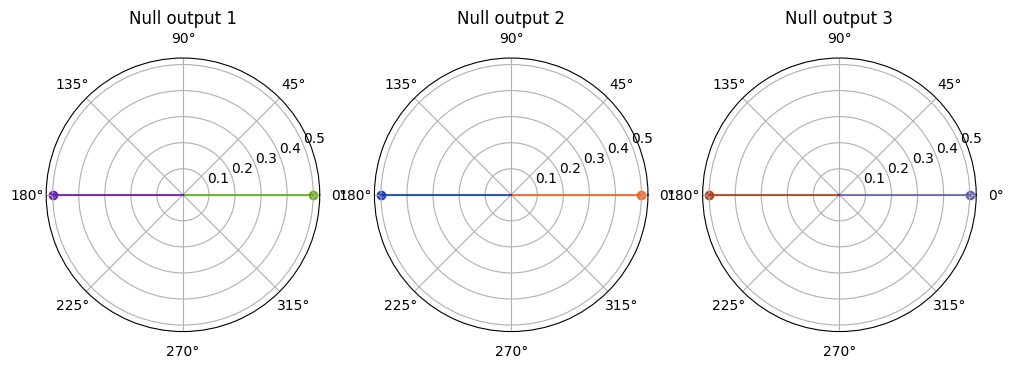

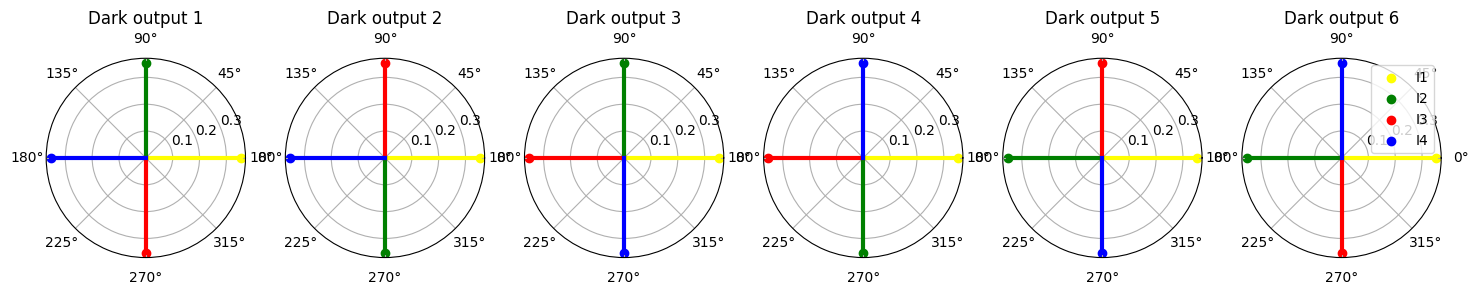

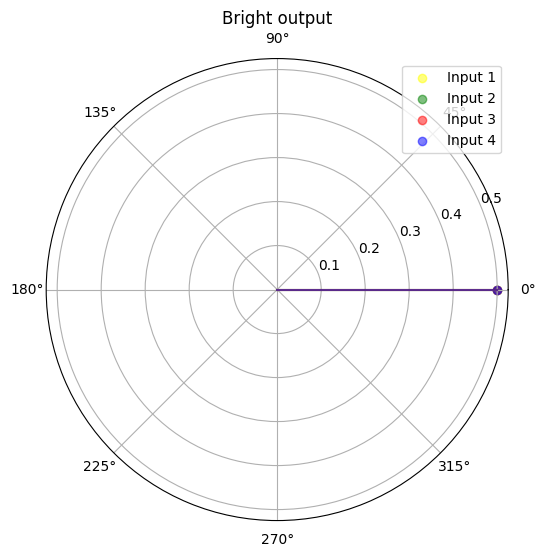

In [17]:
def plot_kn_phase_effect():

    input1_signal = np.array([1+0j, 0, 0, 0])
    input2_signal = np.array([0, 1+0j, 0, 0])
    input3_signal = np.array([0, 0, 1+0j, 0])
    input4_signal = np.array([0, 0, 0, 1+0j])

    nulls1, darks1, _, bright1 = kn(input1_signal)
    nulls2, darks2, _, bright2 = kn(input2_signal)
    nulls3, darks3, _, bright3 = kn(input3_signal)
    nulls4, darks4, _, bright4 = kn(input4_signal)

    # Using first signal as reference
    nulls2 = np.abs(nulls2) * np.exp(1j * (np.angle(nulls2) - np.angle(nulls1)))
    nulls3 = np.abs(nulls3) * np.exp(1j * (np.angle(nulls3) - np.angle(nulls1)))
    nulls4 = np.abs(nulls4) * np.exp(1j * (np.angle(nulls4) - np.angle(nulls1)))
    darks2 = np.abs(darks2) * np.exp(1j * (np.angle(darks2) - np.angle(darks1)))
    darks3 = np.abs(darks3) * np.exp(1j * (np.angle(darks3) - np.angle(darks1)))
    darks4 = np.abs(darks4) * np.exp(1j * (np.angle(darks4) - np.angle(darks1)))
    bright2 = np.abs(bright2) * np.exp(1j * (np.angle(bright2) - np.angle(bright1)))
    bright3 = np.abs(bright3) * np.exp(1j * (np.angle(bright3) - np.angle(bright1)))
    bright4 = np.abs(bright4) * np.exp(1j * (np.angle(bright4) - np.angle(bright1)))
    nulls1 = np.abs(nulls1) * np.exp(1j * 0)
    darks1 = np.abs(darks1) * np.exp(1j * 0)
    bright1 = np.abs(bright1) * np.exp(1j * 0)

    # Null outputs
    _, axs = plt.subplots(1, 3, figsize=(12, 12), subplot_kw={'projection': 'polar'})
    for null in range(3):
        axs[null].scatter(np.angle(nulls1[null]), np.abs(nulls1[null]), color="yellow", label='Input 1', alpha=0.5)
        axs[null].plot([0, np.angle(nulls1[null])], [0, np.abs(nulls1[null])], color="yellow", alpha=0.5)
        axs[null].scatter(np.angle(nulls2[null]), np.abs(nulls2[null]), color="green", label='Input 2', alpha=0.5)
        axs[null].plot([0, np.angle(nulls2[null])], [0, np.abs(nulls2[null])], color="green", alpha=0.5)
        axs[null].scatter(np.angle(nulls3[null]), np.abs(nulls3[null]), color="red", label='Input 3', alpha=0.5)
        axs[null].plot([0, np.angle(nulls3[null])], [0, np.abs(nulls3[null])], color="red", alpha=0.5)
        axs[null].scatter(np.angle(nulls4[null]), np.abs(nulls4[null]), color="blue", label='Input 4', alpha=0.5)
        axs[null].plot([0, np.angle(nulls4[null])], [0, np.abs(nulls4[null])], color="blue", alpha=0.5)
        axs[null].set_title(f'Null output {null+1}')

    # Dark outputs
    _, axs = plt.subplots(1, 6, figsize=(18, 12), subplot_kw={'projection': 'polar'})
    for dark in range(6):
        axs[dark].scatter(np.angle(darks1[dark]), np.abs(darks1[dark]), color="yellow", label='I1', alpha=1)
        axs[dark].plot([0, np.angle(darks1[dark])], [0, np.abs(darks1[dark])], color="yellow", alpha=1, linewidth=3)
        axs[dark].scatter(np.angle(darks2[dark]), np.abs(darks2[dark]), color="green", label='I2', alpha=1)
        axs[dark].plot([0, np.angle(darks2[dark])], [0, np.abs(darks2[dark])], color="green", alpha=1, linewidth=3)
        axs[dark].scatter(np.angle(darks3[dark]), np.abs(darks3[dark]), color="red", label='I3', alpha=1)
        axs[dark].plot([0, np.angle(darks3[dark])], [0, np.abs(darks3[dark])], color="red", alpha=1, linewidth=3)
        axs[dark].scatter(np.angle(darks4[dark]), np.abs(darks4[dark]), color="blue", label='I4', alpha=1)
        axs[dark].plot([0, np.angle(darks4[dark])], [0, np.abs(darks4[dark])], color="blue", alpha=1, linewidth=3)
        axs[dark].set_title(f'Dark output {dark+1}')
    axs[-1].legend()

    # Bright output
    _, ax = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={'projection': 'polar'})
    ax.scatter(np.angle(bright1), np.abs(bright1), color="yellow", label='Input 1', alpha=0.5)
    ax.plot([0, np.angle(bright1)], [0, np.abs(bright1)], color="yellow", alpha=0.5)
    ax.scatter(np.angle(bright2), np.abs(bright2), color="green", label='Input 2', alpha=0.5)
    ax.plot([0, np.angle(bright2)], [0, np.abs(bright2)], color="green", alpha=0.5)
    ax.scatter(np.angle(bright3), np.abs(bright3), color="red", label='Input 3', alpha=0.5)
    ax.plot([0, np.angle(bright3)], [0, np.abs(bright3)], color="red", alpha=0.5)
    ax.scatter(np.angle(bright4), np.abs(bright4), color="blue", label='Input 4', alpha=0.5)
    ax.plot([0, np.angle(bright4)], [0, np.abs(bright4)], color="blue", alpha=0.5)
    ax.set_title('Bright output')
    ax.legend()

plot_kn_phase_effect()

## 🗺️ Transmission maps

The nulling technic with two telescope show a limitation: if the planet light arrive on the two telescopes with a phase shift of $2n\pi$, the light will also be cancelled. It result in a comb-shaped transmission map, perpendicular to the baseline (there is clear bands where it's optimal to detect the planet and black bands where we will mostly destroy the planet light).

The idea of Bracewell was to rotate the baseline in order to let the planet pass through the clear bands at some point. After an entire rotation of the baseline, we will have a sinusoidal signal from which the frequency will indicate us the distance of the planet to it's star, and the phase will give us a clue about the angle between the axes star-planet and the axes of the baseline. Thus, as the transmission map is symmetric, we can constrain the planet position to 2 possible locations, on both sides of the star.

Here, we are using 4 telescopes, resulting in more complexe transmission maps than simple combs, but the principle is the same.

In [18]:
@nb.njit()
def get_uv_map_njit(resolution:int=100, fov:float=FOV.to(u.rad).value) -> tuple[np.ndarray[float], np.ndarray[float], np.ndarray[float], np.ndarray[float]]:
    """
    Generate a map of theta and alpha values for a given resolution.

    Parameters
    ----------
    - resolution: Resolution of the map
    - fov: Range of field of view values
    - alpha: Initial parallactic angle

    Returns
    -------
    - Normalized U map (resolution x resolution)
    - Normalized V map (resolution x resolution)
    - Theta map (resolution x resolution)
    - Alpha map (resolution x resolution)
    """

    # Recreate np.meshgrid() compatible with numba
    x = np.zeros((resolution, resolution))
    y = np.zeros((resolution, resolution))
    for i, v in enumerate(np.linspace(-1, 1, resolution)):
        x[:, i] = v
        y[i, :] = v

    theta_map = np.sqrt(x**2 + y**2) * fov
    alpha_map = np.arctan2(y, x)
    alpha_map = alpha_map % (2*np.pi)

    return x, y, theta_map, alpha_map

def get_uv_map(
    resolution: int = 100,
    fov: u.Quantity = FOV,
    alpha:u.Quantity = ALPHA,
) -> tuple[np.ndarray[float], np.ndarray[float], u.Quantity, u.Quantity]:
    """
    Generate a map of theta and alpha values for a given resolution.

    Parameters
    ----------
    - resolution: Resolution of the map
    - fov: Range of field of view values
    - alpha: Initial parallactic angle

    Returns
    -------
    - Normalized U map (resolution x resolution)
    - Normalized V map (resolution x resolution)
    - Theta map (resolution x resolution)
    - Alpha map (resolution x resolution)
    """

    x, y, theta_map, alpha_map = get_uv_map_njit(resolution=resolution, fov=fov.to(u.rad).value)

    theta_map *= fov.unit
    alpha_map = (alpha_map * u.rad).to(alpha.unit)

    return x, y, theta_map, alpha_map

In [19]:
@nb.njit()
def alpha_theta_to_uv_njit(
        alpha: float = ALPHA.to(u.rad).value,
        theta: float = THETA.to(FOV.unit).value,
        norm_by_fov: float = 1
    ) -> tuple[float, float]:
    """
    Convert alpha and theta values to U and V values.

    Parameters
    ----------
    - alpha: Parallactic angle (rad)
    - theta: Angular separation (rad)
    - fov: Field of view (rad)

    Returns
    -------
    - U value
    - V value
    """

    normalized_theta = theta / norm_by_fov

    x = normalized_theta * np.cos(alpha)
    y = normalized_theta * np.sin(alpha)

    return x, y

def alpha_theta_to_uv(
    alpha: u.Quantity = ALPHA,
    theta: u.Quantity = THETA,
    norm_by_fov: u.Quantity = 1*THETA.unit,
) -> tuple[u.Quantity, u.Quantity]:
    """
    Convert alpha and theta values to U and V values.

    Parameters
    ----------
    - alpha: Parallactic angle
    - theta: Angular separation
    - fov: Field of view

    Returns
    -------
    - U value
    - V value
    """
        
    return alpha_theta_to_uv_njit(
        alpha = alpha.to(u.rad).value,
        theta = theta.to(FOV.unit).value,
        norm_by_fov = norm_by_fov.value
    )

In [20]:
@nb.njit()
def get_transmission_map_njit(
    resolution: int = 100,
) -> tuple[np.ndarray[complex], np.ndarray[complex], np.ndarray[float]]:
    """
    Generate all the kernel-nuller transmission maps for a given resolution

    Parameters
    ----------
    - resolution: Resolution of the map

    Returns
    -------
    - Null outputs map (3 x resolution x resolution)
    - Dark outputs map (6 x resolution x resolution)
    - Kernel outputs map (3 x resolution x resolution)
    """

    _, _, theta_map, alpha_map = get_uv_map_njit(resolution=resolution)

    null_maps = np.zeros((3, resolution, resolution), dtype=np.complex128)
    dark_maps = np.zeros((6, resolution, resolution), dtype=np.complex128)
    kernel_maps = np.zeros((3, resolution, resolution), dtype=float)

    for x in range(resolution):
        for y in range(resolution):

            new_theta = theta_map[x, y]
            new_alpha = alpha_map[x, y]

            signals = acquire_signals_njit(
                amplitude=STAR_LIGHT,
                angular_separation=new_theta,
                alpha=new_alpha,
            )

            nulls, darks, kernels, bright = kn_njit(signals)

            for i in range(3):
                null_maps[i, x, y] = nulls[i]

            for i in range(6):
                dark_maps[i, x, y] = darks[i]

            for i in range(3):
                kernel_maps[i, x, y] = kernels[i]

    return np.abs(null_maps) ** 2, np.abs(dark_maps) ** 2, kernel_maps


def get_transmission_map(
    resolution=100,
) -> tuple[np.ndarray[complex], np.ndarray[complex], np.ndarray[float]]:
    """
    Generate all the kernel-nuller transmission maps for a given resolution

    Parameters
    ----------
    - resolution: Resolution of the map

    Returns
    -------
    - Null outputs map (3 x resolution x resolution)
    - Dark outputs map (6 x resolution x resolution)
    - Kernel outputs map (3 x resolution x resolution)
    """

    return get_transmission_map_njit(
        resolution=resolution
    )

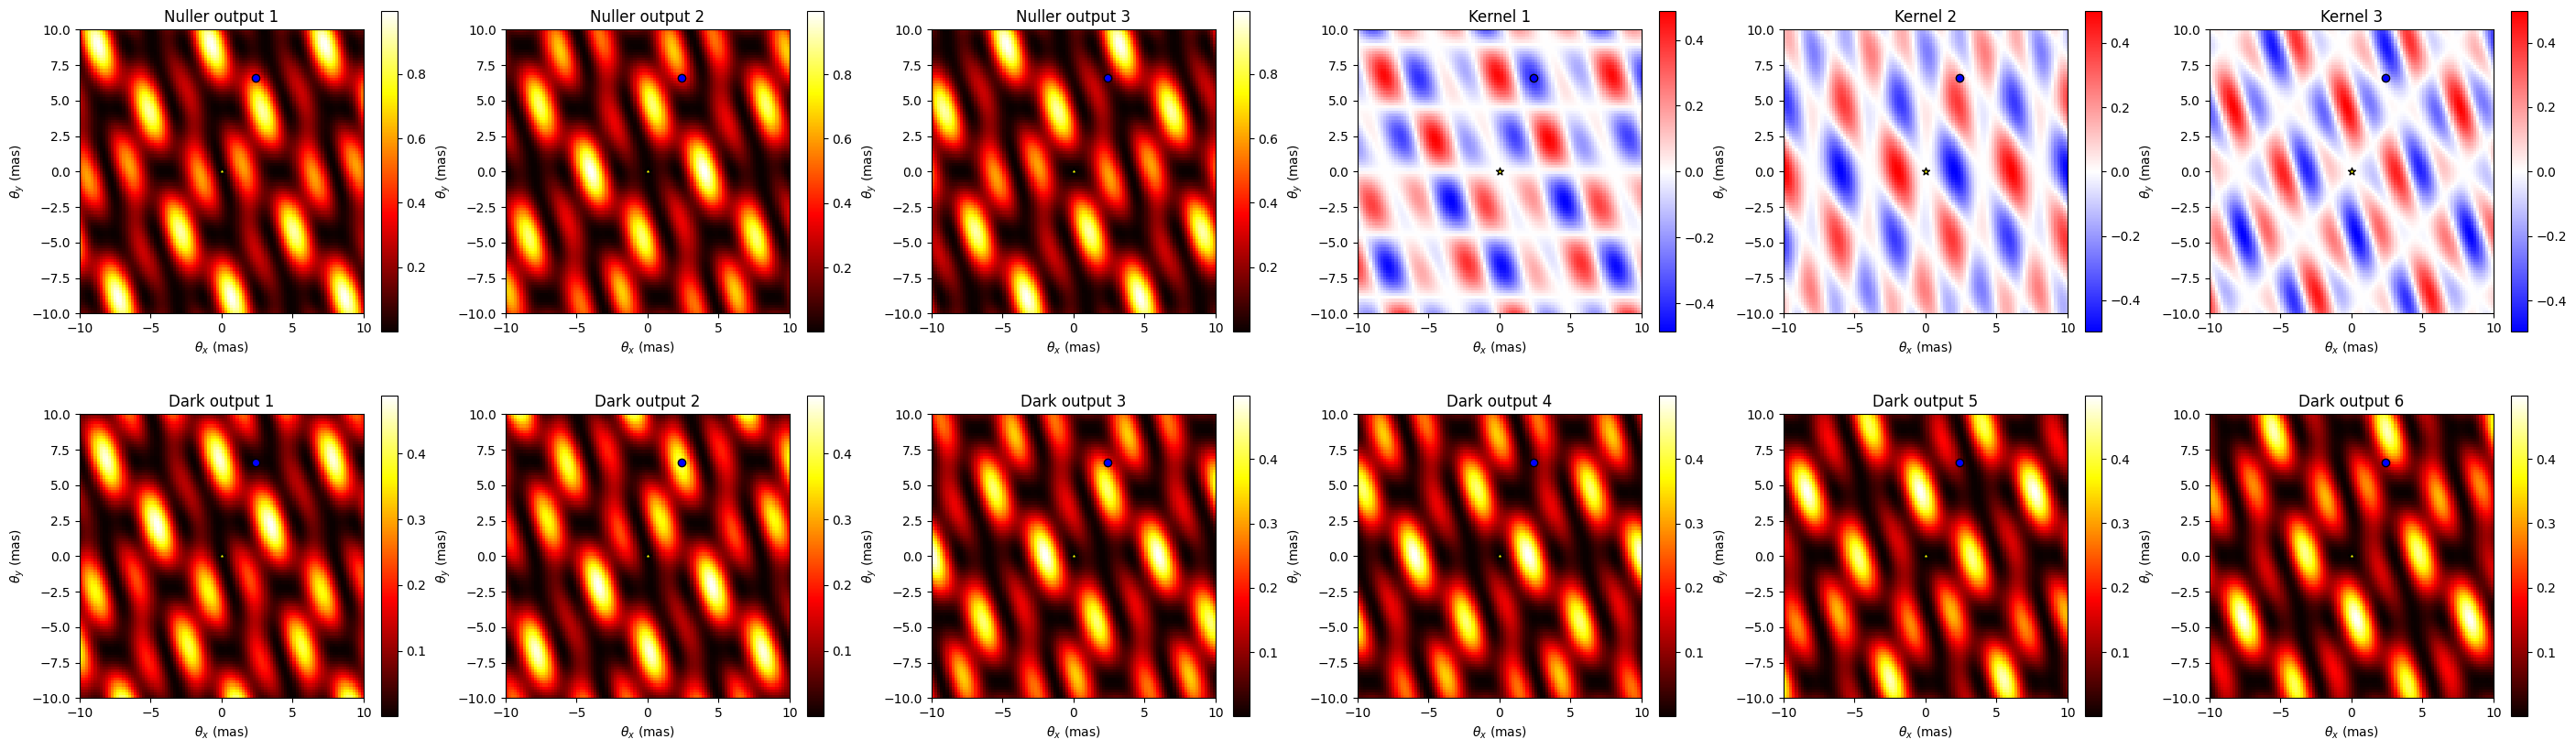

Planet intensity in input:          2.50e-05 | 2.50e-05 | 2.50e-05 | 2.50e-05
Planet intensity on null outputs:   4.46e-05 | 3.67e-05 | 9.71e-06
Planet intensity on dark outputs:   5.62e-07 | 4.01e-05 | 2.19e-05 | 5.22e-06 | 7.72e-06 | 1.55e-05
Planet intensity on kernel outputs: -3.95e-05 | 1.67e-05 | -7.76e-06
Planet intensity on bright output:  8.99e-06


In [21]:
def plot_transmission_maps(
    resolution: int = 100,
) -> None:
    
    null_maps, dark_maps, kernel_maps = get_transmission_map(resolution)
    
    planet_x, planet_y = alpha_theta_to_uv(ALPHA, THETA)

    _, axs = plt.subplots(2, 6, figsize=(35, 10))
    for i in range(3):
        im = axs[0, i].imshow(
            null_maps[i], aspect="equal", cmap="hot", extent=EXTENT
        )
        axs[0, i].set_title(f"Nuller output {i+1}")
        axs[0, i].set_xlabel(r"$\theta_x$" + f" ({FOV.unit})")
        axs[0, i].set_ylabel(r"$\theta_y$" + f" ({FOV.unit})")
        plt.colorbar(im, ax=axs[0, i])

        axs[0, i].scatter(0, 0, color="yellow", marker="*", edgecolors="black")
        axs[0, i].scatter(planet_x, planet_y, color="blue", edgecolors="black")

    for i in range(6):
        im = axs[1, i].imshow(
            dark_maps[i], aspect="equal", cmap="hot", extent=EXTENT
        )
        axs[1, i].set_title(f"Dark output {i+1}")
        axs[1, i].set_xlabel(r"$\theta_x$" + f" ({FOV.unit})")
        axs[1, i].set_ylabel(r"$\theta_y$" + f" ({FOV.unit})")
        axs[1, i].set_aspect("equal")
        plt.colorbar(im, ax=axs[1, i])

        axs[1, i].scatter(0, 0, color="yellow", marker="*", edgecolors="black")
        axs[1, i].scatter(planet_x, planet_y, color="blue", edgecolors="black")

    for i in range(3):
        im = axs[0, i + 3].imshow(
            kernel_maps[i], aspect="equal", cmap="bwr", extent=EXTENT
        )
        axs[0, i + 3].set_title(f"Kernel {i+1}")
        axs[0, i + 3].set_xlabel(r"$\theta_x$" + f" ({FOV.unit})")
        axs[0, i + 3].set_ylabel(r"$\theta_y$" + f" ({FOV.unit})")
        plt.colorbar(im, ax=axs[0, i + 3])

        axs[0, i + 3].scatter(0, 0, color="yellow", marker="*", edgecolors="black")
        axs[0, i + 3].scatter(planet_x, planet_y, color="blue", edgecolors="black")

    plt.show()

    signals = acquire_signals(PLANET_LIGHT)
    nulls, darks, kernels, bright = kn(signals,)

    print(
        f"Planet intensity in input:          {' | '.join([f'{np.abs(i)**2:.2e}' for i in PLANET_SIGNALS])}"
    )

    print(
        f"Planet intensity on null outputs:   {' | '.join([f'{np.abs(n)**2:.2e}' for n in nulls])}"
    )

    print(
        f"Planet intensity on dark outputs:   {' | '.join([f'{np.abs(d)**2:.2e}' for d in darks])}"
    )

    print(
        f"Planet intensity on kernel outputs: {' | '.join([f'{k:.2e}' for k in kernels])}"
    )

    print(f"Planet intensity on bright output:  {np.abs(bright)**2:.2e}")

plot_transmission_maps(resolution=100)

---

<div align=center>

# ⚙️ **Data generation**

</div>

## 🟨 Single observation

In [22]:
@nb.njit()
def bulk_observation_jitted(
    N: int = 1000,  # Number of observations
    star_signals: np.array = STAR_SIGNALS,  # Star signals
    planet_signals: np.array = PLANET_SIGNALS,  # Planet signals
    input_opd_rms: float = INPUT_OPD_RMS.to(L.unit).value,  # Input OPD RMS
    wavelength: float = L.value,  # Wavelength
):
    """
    Simulate several observation of the Kernel-Nuller.

    Parameters
    ----------
    - N: Number of observations
    - star_signals: Star signals
    - planet_signals: Planet signals
    - input_opd_rms: Input OPD RMS
    - wavelength: Wavelength

    Returns
    -------
    - Nulls outputs intensities (3 x N)
    - Darks outputs intensities (6 x N)
    - Kernels outputs intensities (3 x N)
    - Cumulative kernel outputs intensities (N)
    """

    nulls_dist_so = np.empty((3, N))
    nulls_dist_wp = np.empty((3, N))
    darks_dist_so = np.empty((6, N))
    darks_dist_wp = np.empty((6, N))
    kernels_dist_so = np.empty((3, N))
    kernels_dist_wp = np.empty((3, N))
    kernels_dist_so = np.empty((3, N))
    kernels_dist_wp = np.empty((3, N))
    cumul_dist_so = np.empty(N)
    cumul_dist_wp = np.empty(N)

    for i in range(N):
        noise = random_normal(input_opd_rms, 4)
        noised_star_signals = phase_shift_njit(star_signals, noise, wavelength)

        # Star only ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        nulls_so, darks_so, kernels_so, bright_so = kn_njit(
            noised_star_signals, wavelength
        )

        nulls_int_so = np.abs(nulls_so) ** 2
        for j in range(3):
            nulls_dist_so[j, i] = nulls_int_so[j]

        darks_int_so = np.abs(darks_so) ** 2
        for j in range(6):
            darks_dist_so[j, i] = darks_int_so[j]

        for j in range(3):
            kernels_dist_so[j, i] = kernels_so[j]

        cumul_dist_so[i] = (
            np.abs(kernels_so[0]) + np.abs(kernels_so[1]) + np.abs(kernels_so[2])
        )

        # With planet ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        noised_planet_signals = phase_shift_njit(planet_signals, noise, wavelength)
        nulls_wp, darks_wp, kernels_wp, bright_wp = kn_njit(
            planet_signals, wavelength
        )

        nulls_int_wp = np.abs(nulls_wp) ** 2 + nulls_int_so
        for j in range(3):
            nulls_dist_wp[j, i] = nulls_int_wp[j]

        darks_int_wp = np.abs(darks_wp) ** 2 + darks_int_so
        for j in range(6):
            darks_dist_wp[j, i] = darks_int_wp[j]

        for j in range(3):
            kernels_dist_wp[j, i] = kernels_wp[j] + kernels_so[j]

        cumul_dist_wp[i] = (
            np.abs(kernels_wp[0] + kernels_so[0])
            + np.abs(kernels_wp[1] + kernels_so[1])
            + np.abs(kernels_wp[2] + kernels_so[2])
        )

    return (
        nulls_dist_so,
        nulls_dist_wp,
        darks_dist_so,
        darks_dist_wp,
        kernels_dist_so,
        kernels_dist_wp,
        cumul_dist_so,
        cumul_dist_wp,
    )


# User-friendly interface (Numba can't manage dicts with unconsistent data)
def bulk_observation(
    N: int = 1000,
    star_signals: np.ndarray[complex] = STAR_SIGNALS,
    planet_signals: np.ndarray[complex] = PLANET_SIGNALS,
    input_opd_rms: u.Quantity = INPUT_OPD_RMS,
    wavelength: u.Quantity = L,
):
    """
    Simulate several observation of the Kernel-Nuller.
    
    Parameters
    ----------
    - N: Number of observations
    - star_signals: Star signals
    - planet_signals: Planet signals
    - input_opd_rms: Input OPD RMS
    - wavelength: Wavelength

    Returns
    -------
    - Nulls outputs intensities (3 x N)
    - Darks outputs intensities (6 x N)
    - Kernels outputs intensities (3 x N)
    - Cumulative kernel outputs intensities (N)
    """

    bulk_list = bulk_observation_jitted(
        N,
        star_signals,
        planet_signals,
        input_opd_rms.to(wavelength.unit).value,
        wavelength.value,
    )
    return {
        "nulls_so": bulk_list[0],
        "nulls_wp": bulk_list[1],
        "darks_so": bulk_list[2],
        "darks_wp": bulk_list[3],
        "kernels_so": bulk_list[4],
        "kernels_wp": bulk_list[5],
        "cumul_so": bulk_list[6],
        "cumul_wp": bulk_list[7],
    }

DISTS_DATA = bulk_observation()

## 🟡 Parallactic diversity

In [23]:
def get_parallactic_diversity_data(N=1000, alpha_range=ALPHA_RANGE):
    """
    Get the data for the parallactic diversity study.

    Parameters
    ----------
    - N: Number of observations per angle
    - alpha_range: Range of parallactic angles

    Returns 
    -------
    - Array of medians of the 3 kernel outputs for each parallactic angle (3 x len(alpha_range))
    """

    data = np.zeros((3, len(alpha_range)))
    for i, alpha in enumerate(alpha_range):

        dists = bulk_observation(
            N=1000,
            planet_signals=acquire_signals(PLANET_LIGHT, alpha=ALPHA + alpha),
            # input_opd_rms=L/50
        )

        for k in range(3):
            data[k, i] = np.median(dists['kernels_wp'][k])

    return data

PARALLACTIC_DIVERSITY_DATA = get_parallactic_diversity_data()

---

<div align=center>

# 🔎 **Data analysis**

</div>

## 📊 Output distributions

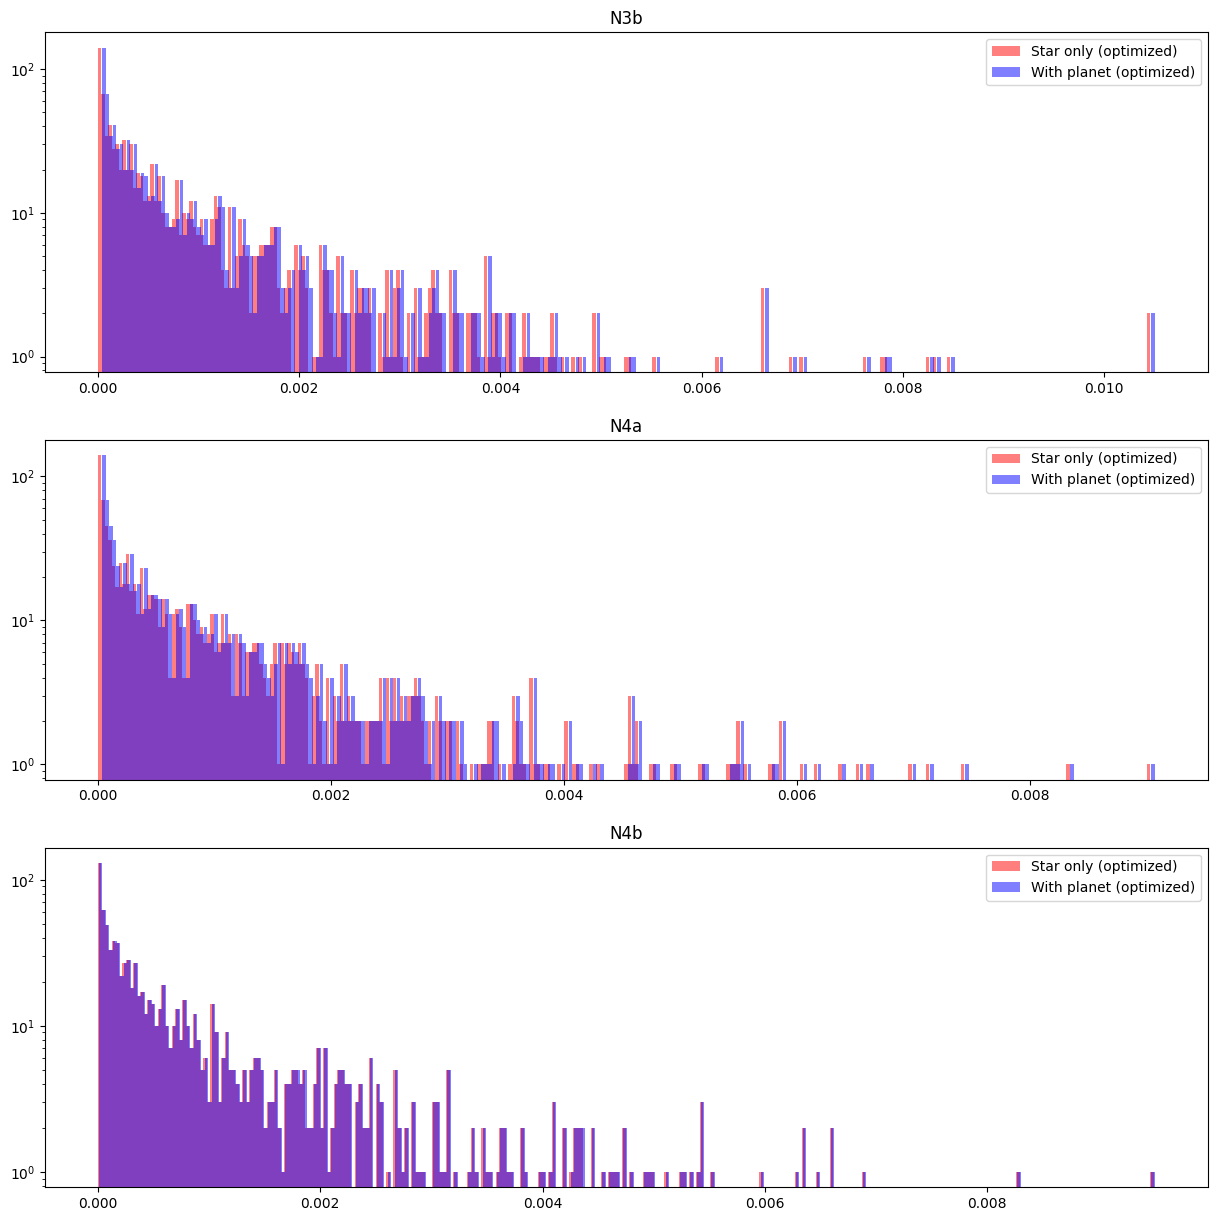

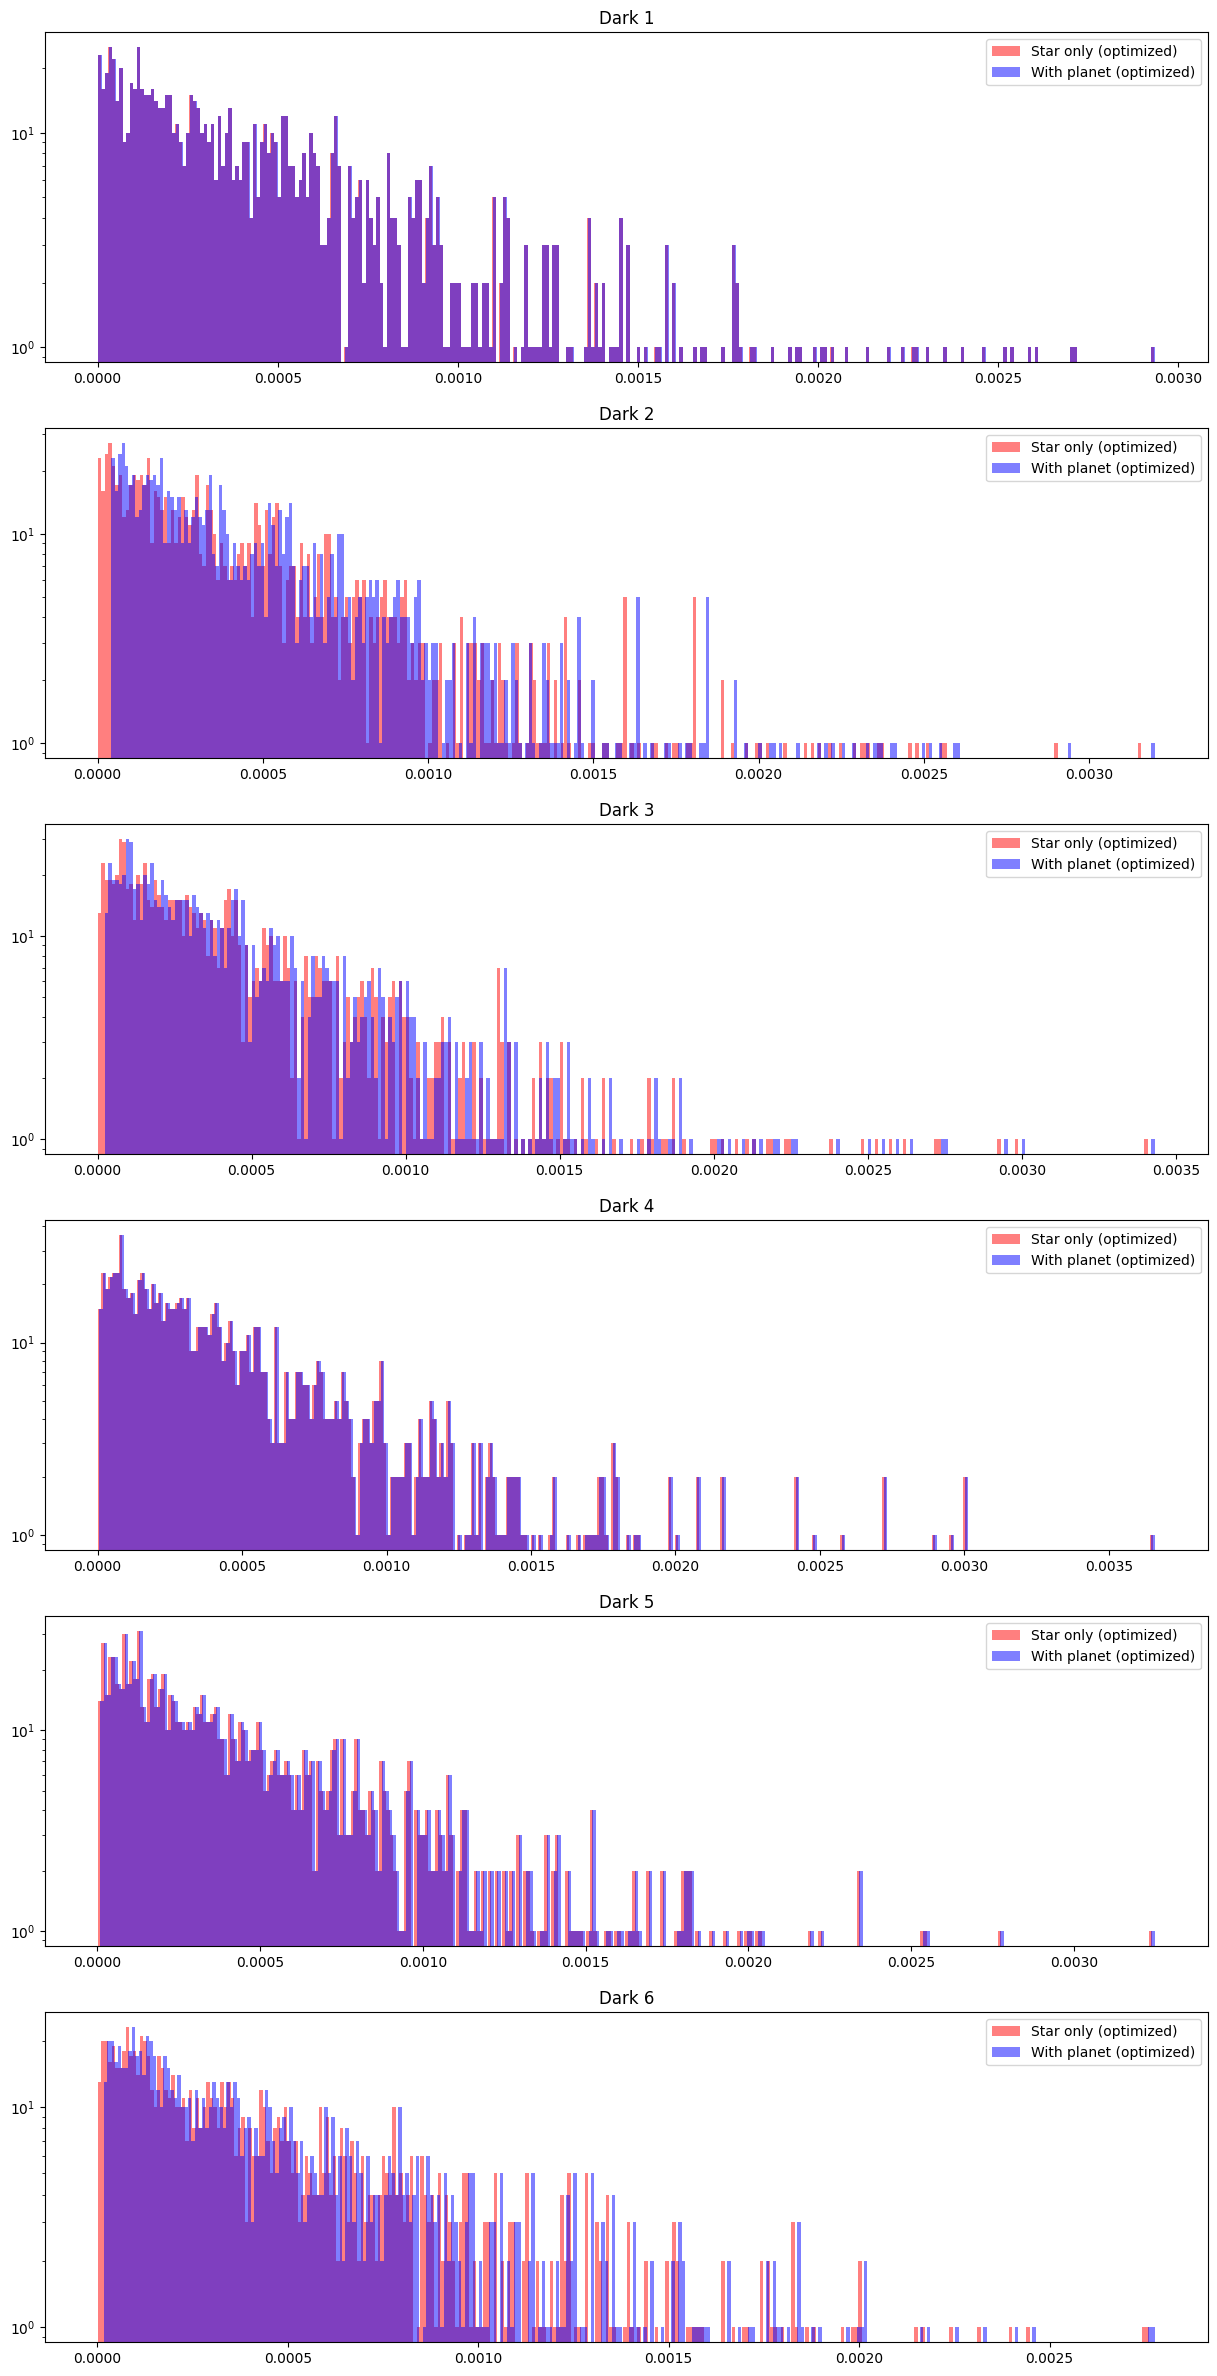

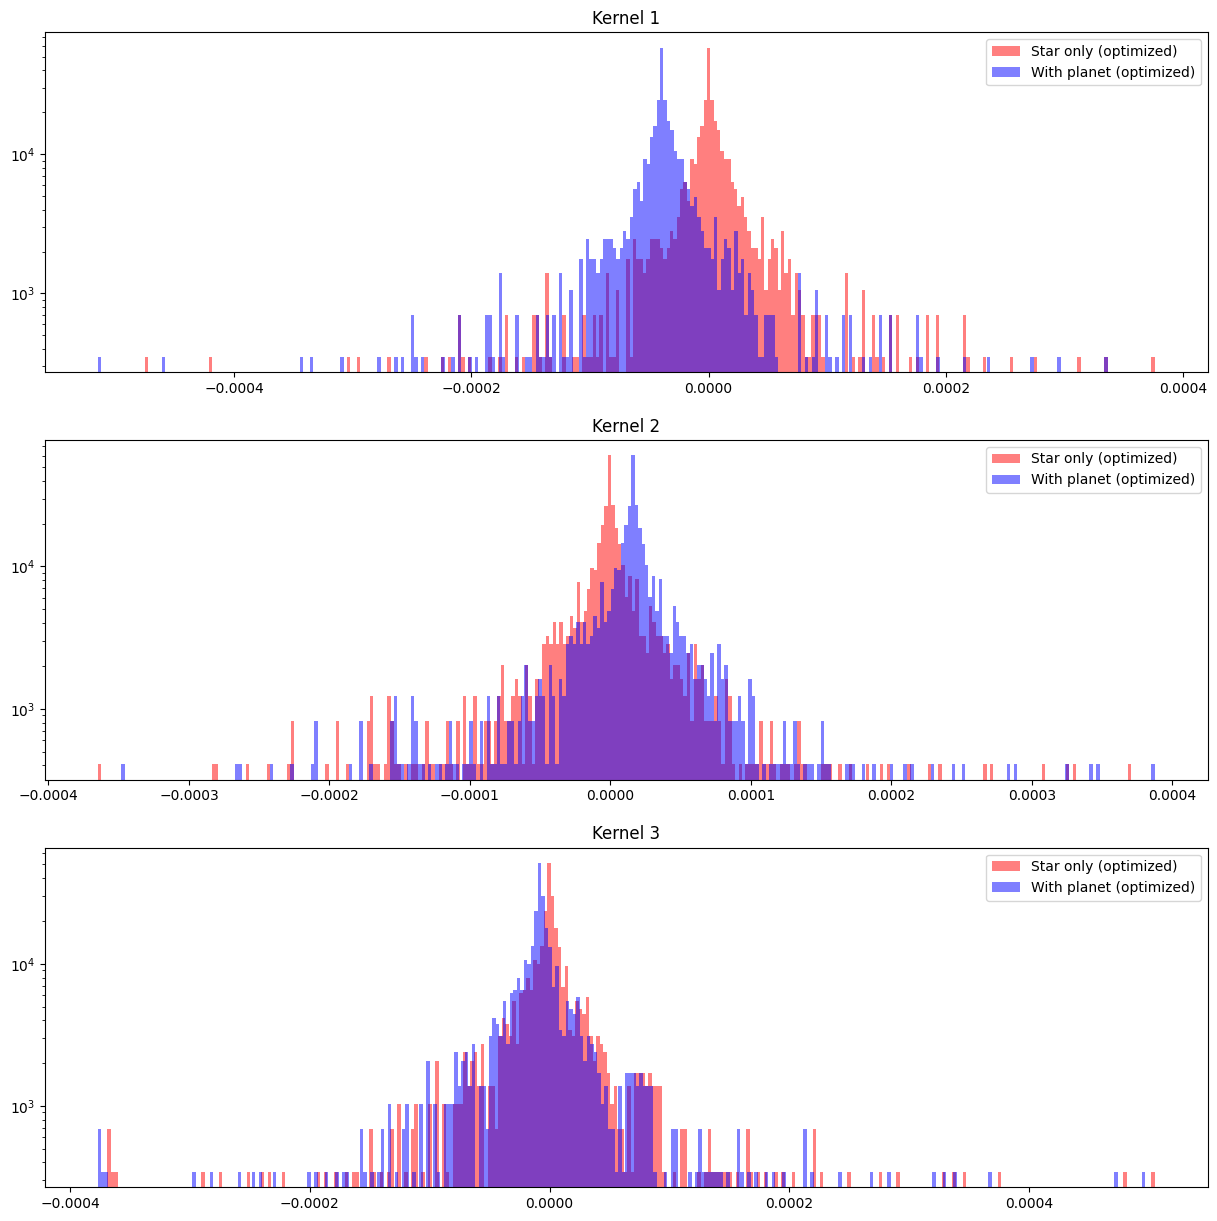

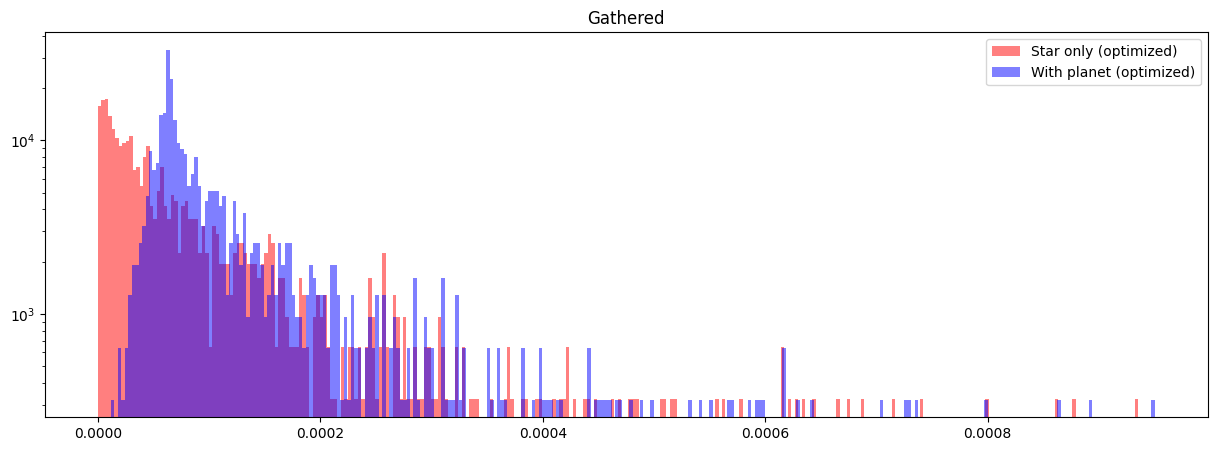

In [24]:
def plot_distributions(data=DISTS_DATA):

    null_outputs = ['N3b', 'N4a', 'N4b']

    # Plots -----------------------------------------------------------------------

    bins = 300

    # Nuller ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    fig, axs = plt.subplots(3, 1, figsize=(15, 15))
    for i in range(3):
        ax = axs[i]

        # Histograms ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        n1,_,_ = ax.hist(data['nulls_so'][i], bins=bins, color='red', label=f"Star only (optimized)", alpha = 0.5, log=True)
        n2,_,_ = ax.hist(np.array(data['nulls_wp'][i]), bins=bins, color='blue', label=f"With planet (optimized)", alpha = 0.5, log=True)
        m = max(max(n1), max(n2))

        ax.set_title(f"{null_outputs[i]}")
        ax.legend()

    # Dark ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
    fig, axs = plt.subplots(6, 1, figsize=(15, 30))
    for i in range(6):
        ax = axs[i]

        # Histograms ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        n1,_,_ = ax.hist(data['darks_so'][i], bins=bins, color='red', label=f"Star only (optimized)", alpha=0.5, log=True)
        n2,_,_ = ax.hist(np.array(data['darks_wp'][i]), bins=bins, color='blue', label=f"With planet (optimized)", alpha=0.5, log=True)
        m = max(max(n1), max(n2))

        ax.set_title(f"Dark {i+1}")
        ax.legend()

    # Kernel ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    fig, axs = plt.subplots(3, 1, figsize=(15, 15))
    for i in range(3):
        ax = axs[i]

        # Histograms ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        n1,_,_ = ax.hist(data['kernels_so'][i], bins=bins, color='red', label=f"Star only (optimized)", density=True, alpha=0.5, log=True)
        n2,_,_ = ax.hist(np.array(data['kernels_wp'][i]), bins=bins, color='blue', label=f"With planet (optimized)", density=True, alpha=0.5, log=True)
        m = max(max(n1), max(n2))
        
        ax.set_title(f"Kernel {i+1}")
        ax.legend()

    # Gathered ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    # Histograms ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    n1,_,_ = ax.hist(data['cumul_so'], bins=bins, color='red', label=f"Star only (optimized)", density=True, alpha=0.5, log=True)
    n2,_,_ = ax.hist(data['cumul_wp'], bins=bins, color='blue', label=f"With planet (optimized)", density=True, alpha=0.5, log=True)
    m = max(max(n1), max(n2))

    ax.set_title(f"Gathered")
    ax.legend()

    plt.show()

plot_distributions()

## 📢 Noise sensitivity

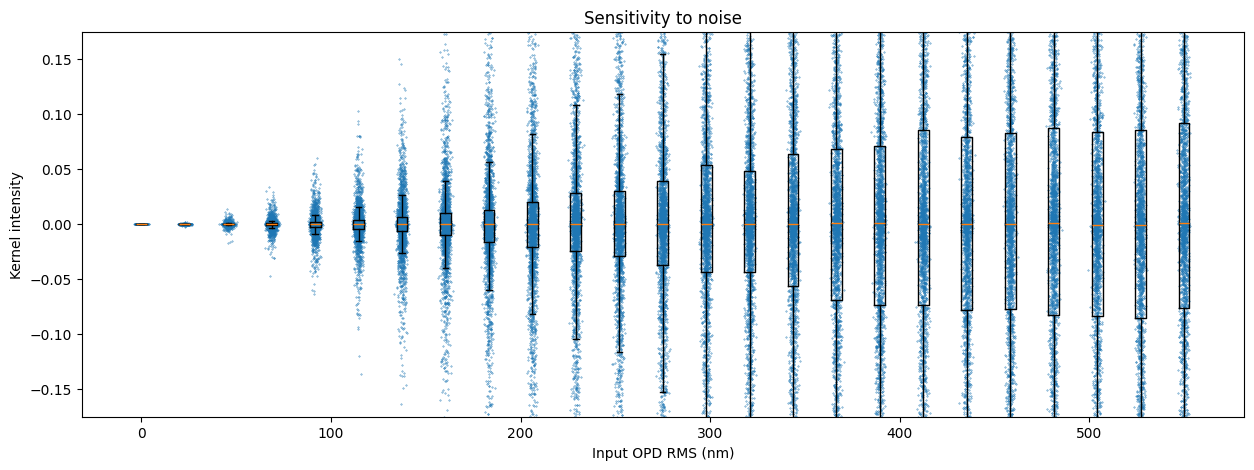

In [25]:
def plot_sensitivity_to_noise():

    input_opd_rms_range, step = np.linspace(0, L.value/3, 25, retstep=True)
    input_opd_rms_range = (input_opd_rms_range * L.unit).to(u.nm)
    step = (step * L.unit).to(u.nm)

    stds = []

    _, ax = plt.subplots(1, 1, figsize=(15, 5))

    for i, input_opd_rms in enumerate(input_opd_rms_range):

        dists = bulk_observation(1000, STAR_SIGNALS, np.zeros(4, dtype=np.complex128)*L.unit, input_opd_rms, L)
        kernel_dist = np.concatenate([*dists['kernels_so']])
        stds.append(np.std(kernel_dist))

        ax.scatter(np.random.normal(input_opd_rms.value, step.value/20, len(kernel_dist)), kernel_dist, color='tab:blue', s=0.1, alpha=1)
        ax.boxplot(kernel_dist, vert=True, positions=[input_opd_rms.value],widths=step.value/4, showfliers=False, manage_ticks=False)

    ax.set_ylim(-max(stds), max(stds))
    ax.set_xlabel(f"Input OPD RMS ({input_opd_rms_range.unit})")
    ax.set_ylabel("Kernel intensity")
    ax.set_title("Sensitivity to noise")

plot_sensitivity_to_noise()

## ☑️ Model fitting (WIP)

2024-05-21 10:42:04.850 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=1692094430.639078)
2024-05-21 10:42:04.855 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=953811364.95783)
2024-05-21 10:42:04.857 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=1617183379.335086)
2024-05-21 10:42:04.875 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=1550585555.402657)
2024-05-21 10:42:04.878 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=1608889048.107168)
2024-05-21 10:42:04.937 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=83733342.78124)
2024-05-21 10:42:05.101 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=985924401.628805)
2024-05-21 10:42:05.175 | INFO

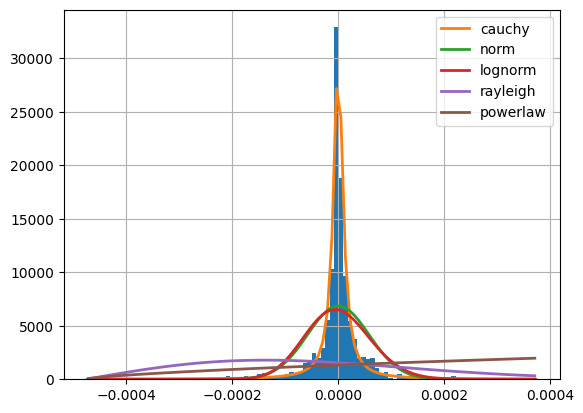

In [26]:
def fit(data):
    f = fitter.Fitter(data,
           distributions=fitter.get_common_distributions())
    f.fit()
    f.summary()

fit(DISTS_DATA['kernels_so'][0])

## ❓ ROC tests (WIP)

In [27]:
def argmax(data, resolution):
    hist = np.histogram(data, bins=resolution)
    return hist[1][np.argmax(hist[0])]
    # right_edge = hist[1][np.argmax(hist[0])+1]
    # return (left_edge + right_edge) / 2

estimators = {
    'Argmax100': lambda data: abs(argmax(data, 100)),
    'Argmax50': lambda data: abs(argmax(data, 50)),
    'Argmax500': lambda data: abs(argmax(data, 500)),
    'Mean': lambda data: abs(np.mean(data)),
    'Median': lambda data: abs(np.median(data)),
}
cmap = {
    "Argmax100":"blue",
    "Mean":"orange",
    "Median":"green",
    "Argmax50":"red",
    "Argmax500":"purple"
}

T0 = []
T1 = []
Nmc = 1000
size = 1000

# Sequential
@nb.njit()
def ROC(input_opd_rms, wavelenght):
    T0 = np.zeros((Nmc,size))
    T1 = np.zeros((Nmc,size))
    for i in range(Nmc):
        dists = bulk_observation_jitted(size, STAR_SIGNALS, PLANET_SIGNALS, input_opd_rms, wavelenght)
        T0[i] = dists[4][1]
        T1[i] = dists[5][1]
    return T0, T1
T0, T1 = ROC(INPUT_OPD_RMS.value, L.value)

# # Parallel
# with concurrent.futures.ThreadPoolExecutor(20) as executor:
#     results = list(executor.map(
#         lambda x: bulk_observation(*x),
#         [(1000, star_signals, planet_signals, optimized_parameters)] * Nmc
#     ))
# T0 = np.array([r['kernels_so'][1] for r in results])
# T1 = np.array([r['kernels_wp'][1] for r in results])


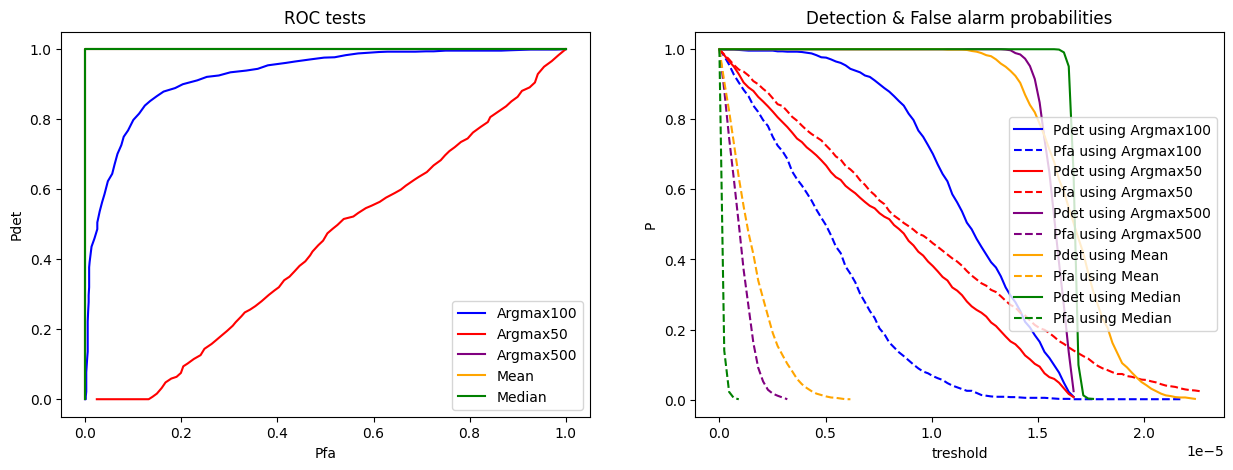

In [28]:
planet_intensity = np.sum(np.abs(PLANET_SIGNALS)**2)

max_estimator = max([
    np.max(np.abs(np.mean(T0, axis=1))),
    np.max(np.abs(np.mean(T1, axis=1))),
    np.max(np.abs(np.median(T0, axis=1))),
    np.max(np.abs(np.median(T1, axis=1))),
    np.max(np.abs(np.array([argmax(t, 100) for t in T0]))),
    np.max(np.abs(np.array([argmax(t, 100) for t in T1])))
])
thresholds = np.linspace(0, max_estimator, 100)

_, axs = plt.subplots(1, 2, figsize=(15, 5))

for name, estimator in estimators.items():
    Pfa = np.zeros(len(thresholds))
    Pdet = np.zeros(len(thresholds))
    for i, threshold in enumerate(thresholds):
        Pfa[i] = np.sum(np.array([estimator(t) for t in T0]) > threshold) / Nmc
        Pdet[i] = np.sum(np.array([estimator(t) for t in T1]) > threshold) / Nmc

    # print(f"\n{name} :")
    # print(Pfa)
    # print(Pdet)

    axs[0].plot(Pfa, Pdet, label=name, color=cmap[name])

    # Trim Pfa and Pdet
    Pfa = Pfa[Pfa > 0]
    Pdet = Pdet[Pdet > 0]

    axs[1].plot(thresholds[:len(Pdet)], Pdet, c=cmap[name], label="Pdet using " + name)
    axs[1].plot(thresholds[:len(Pfa)], Pfa, c=cmap[name], label="Pfa using " + name, linestyle='--')

axs[0].set_xlabel("Pfa")
axs[0].set_ylabel("Pdet")
axs[0].set_title("ROC tests")
axs[0].legend()
axs[1].set_xlabel("treshold")
axs[1].set_ylabel("P")
axs[1].set_title("Detection & False alarm probabilities")
axs[1].legend()
plt.show()